In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.rk import RegressionKriging

# soil 

In [2]:
def classify_soil_texture(sand, silt, clay):
    """
    根据国际土壤质地三角图对土壤质地进行分类，共有12个类别。
    
    参数:
    sand (float): 砂粒百分比 (0-100) >0.2mm
    silt (float): 粉粒百分比 (0-100) >=0.002mm and <0.2mm
    clay (float): 粘粒百分比 (0-100) < 0.002
    
    返回:
    str: 土壤质地分类结果的英文名称
    """
    
    # 检查砂粒、粉粒和粘粒的百分比之和是否接近100%
    if not 98 <= sand + silt + clay <= 102:
        # 如果不符合条件，打印提示信息
        print("砂粒、粉粒和粘粒的百分比之和应大约为100%")

    # 对百分比进行归一化处理，确保它们加起来等于100
    total = sand + silt + clay
    sand, silt, clay = (sand / total * 100, silt / total * 100, clay / total * 100)

    # 根据国际土壤质地三角图进行土壤质地分类的逻辑
    if clay >= 40:
        # 如果粘粒含量大于等于40%
        if silt >= 40:
            return "SiltyClay"  # 粉质粘土
        elif sand <= 45:
            return "Clay"  # 粘土
        else:
            return "SandyClay"  # 沙质粘土
    elif clay >= 27:
        # 如果粘粒含量大于等于27%
        if silt < 28 and sand > 45:
            return "SandyClayLoam"  # 沙质粘壤土
        elif silt >= 28 and silt < 40:
            return "ClayLoam"  # 粘壤土
        else:
            return "SiltyClayLoam"  # 粉质粘壤土
    elif clay >= 20:
        # 如果粘粒含量大于等于20%
        if sand >= 52:
            return "SandyClayLoam"  # 沙质粘壤土
        elif silt >= 50:
            return "SiltyClayLoam"  # 粉质粘壤土
        else:
            return "ClayLoam"  # 粘壤土
    elif silt >= 50:
        # 如果粉粒含量大于等于50%
        if silt >= 80:
            return "Silt"  # 粉土
        else:
            return "SiltLoam"  # 粉壤土
    elif sand >= 85:
        return "Sand"  # 沙土
    elif sand >= 70:
        return "LoamySand"  # 壤沙土
    elif sand >= 52:
        return "SandyLoam"  # 沙壤土
    else:
        return "Loam"  # 壤土


# RF(classifier)

In [3]:
def rf_classics_classification(df, label_col, feature_cols, param_grid, save_model_path):
    # 分离特征和标签
    X = df[feature_cols]
    y = df[label_col]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初步超参数搜索（随机搜索）
    rf = RandomForestClassifier(random_state=42)
    n_iter_search = 100
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=n_iter_search, cv=5, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    
    # 打印最佳参数
    best_random_params = random_search.best_params_
    print('Best Random Parameters: \n', best_random_params)
    
    # 使用最佳参数对测试集进行评估
    best_randomrf = random_search.best_estimator_
    testrandom_score = best_randomrf.score(X_test, y_test)
    trainrandom_score = best_randomrf.score(X_train, y_train)

    print('RandomSearch Test accuracy:', testrandom_score,'RandomSearch Train accuracy:',trainrandom_score)
    
    # 基于随机搜索结果的超参数范围
    print(f"Random search best params: {best_random_params}")
    param_grid_fine = {
        'n_estimators': [max(10, best_random_params['n_estimators'] - 50), best_random_params['n_estimators'], min(1000, best_random_params['n_estimators'] + 50)],
        'max_depth': [max(1, best_random_params['max_depth'] - 5), best_random_params['max_depth'], best_random_params['max_depth'] + 5],
        'min_samples_split': [max(2, best_random_params['min_samples_split'] - 2), best_random_params['min_samples_split'], best_random_params['min_samples_split'] + 2],
        'min_samples_leaf': [max(1, best_random_params['min_samples_leaf'] - 1), best_random_params['min_samples_leaf'], best_random_params['min_samples_leaf'] + 1]
    }
    
    # 精细超参数搜索（网格搜索）
    grid_search = GridSearchCV(estimator=best_randomrf, param_grid=param_grid_fine, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # 最优参数
    best_gr_params = grid_search.best_params_
    best_gr_rf = grid_search.best_estimator_
    
    # 打印最佳参数
    print('Best Grid Parameters: \n', best_gr_params)
    
    # 使用最佳参数对测试集进行评估
    test_gr_score = best_gr_rf.score(X_test, y_test)
    train_gr_score = best_gr_rf.score(X_train, y_train)
    print('GridSearch Test accuracy:', test_gr_score,'GridSearch Train accuracy:',train_gr_score)
    
    # 特征重要性
    feature_gr_importances = best_gr_rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_gr_importances
    }).sort_values(by='Importance', ascending=False)
    
    # 保存特征重要性
    importance_df.to_csv(os.path.join(os.path.dirname(save_model_path), 'feature_importance.csv'), index=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'feature_importance_importance.png'))
    
    # 预测与评估
    y_train_pred = best_gr_rf.predict(X_train)
    y_test_pred = best_gr_rf.predict(X_test)
    
    # 计算评估指标
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # 输出随机森林评估分数
    print(f"Random Forest Accuracy: {accuracy}")
    print(f"Random Forest Precision: {precision}")
    print(f"Random Forest Recall: {recall}")
    print(f"Random Forest F1-score: {f1}")
    
    # 混淆矩阵
    cm = confusion_matrix(y_test, y_test_pred)
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y)))
    plt.xticks(tick_marks, np.unique(y), rotation=45)
    plt.yticks(tick_marks, np.unique(y))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # 在混淆矩阵中添加文本
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'confusion_matrix.png'))
    
    # 绘制评估分数图
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    values = [accuracy, precision, recall, f1]

    bars = plt.bar(metrics, values)
    plt.ylabel('Scores')
    plt.title('Random Forest Classification Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'evaluation_scores.png'))
    
    # 保存模型
    with open(save_model_path, 'wb') as f:
        pickle.dump(best_gr_rf, f)
    
    return {
        "SelectedFeatures": feature_cols,
        "FeatureImportance": importance_df,
        "RandomForest": {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }
    }

# RF(regression)

In [4]:

def rf_classics(df, label_col, feature_cols, coord_cols, param_grid, save_model_path):
    # 分离特征和标签
    X = df[feature_cols + coord_cols]
    y = df[label_col]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初步超参数搜索（随机搜索）
    rf = RandomForestRegressor()
    n_iter_search = 100
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=n_iter_search, cv=5, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    # 打印最佳参数
    best_random_params = random_search.best_params_
    print('Best Random Parameters: \n', best_random_params)
    # 使用最佳参数对测试集进行评估
    best_randomrf = random_search.best_estimator_
    testrandom_score = best_randomrf.score(X_test, y_test)
    trainrandom_score = best_randomrf.score(X_train, y_train)

    print('RandomSearch Test accuracy:', testrandom_score,'RandomSearch Train accuracy:',trainrandom_score)
    # 基于随机搜索结果的超参数范围
    print(f"Random search best params: {best_random_params}")
    param_grid_fine = {
        'n_estimators': [max(10, best_random_params['n_estimators'] - 50), best_random_params['n_estimators'], min(1000, best_random_params['n_estimators'] + 50)],
        'max_depth': [max(1, best_random_params['max_depth'] - 5), best_random_params['max_depth'], best_random_params['max_depth'] + 5],
        'min_samples_split': [max(2, best_random_params['min_samples_split'] - 2), best_random_params['min_samples_split'], best_random_params['min_samples_split'] + 2],
        'min_samples_leaf': [max(1, best_random_params['min_samples_leaf'] - 1), best_random_params['min_samples_leaf'], best_random_params['min_samples_leaf'] + 1]
    }
    # 精细超参数搜索（网格搜索）
    grid_search = GridSearchCV(estimator=best_randomrf, param_grid=param_grid_fine, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    # 最优参数
    best_gr_params = grid_search.best_params_
    best_gr_rf = grid_search.best_estimator_
    # 打印最佳参数
    print('Best Grid Parameters: \n', best_gr_params)
    # 使用最佳参数对测试集进行评估
    test_gr_score = best_gr_rf.score(X_test, y_test)
    train_gr_score = best_gr_rf.score(X_train, y_train)
    print('GridSearch Test accuracy:', test_gr_score,'GridSearch Train accuracy:',train_gr_score)
    # 特征重要性
    feature_gr_importances = best_gr_rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_gr_importances
    }).sort_values(by='Importance', ascending=False)
    
    # 保存特征重要性
    importance_df.to_csv(os.path.join(os.path.dirname(save_model_path), 'feature_importance.csv'), index=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'feature_importance_importance.png'))
    
    # 预测与评估
    y_train_pred = best_gr_rf.predict(X_train)
    y_test_pred = best_gr_rf.predict(X_test)
    
    r2_rf = r2_score(y_test, y_test_pred)
    mae_rf = mean_absolute_error(y_test, y_test_pred)
    mse_rf = mean_squared_error(y_test, y_test_pred)
    rmse_rf = np.sqrt(mse_rf)
    
    # 输出随机森林评估分数
    print(f"Random Forest R2: {r2_rf}")
    print(f"Random Forest MAE: {mae_rf}")
    print(f"Random Forest MSE: {mse_rf}")
    print(f"Random Forest RMSE: {rmse_rf}")
    
    # 计算残差
    residuals_train = y_train - y_train_pred
    
    # 克里金残差训练
    OK = OrdinaryKriging(X_train[coord_cols[0]], X_train[coord_cols[1]], residuals_train, variogram_model='spherical')
    kriging_predictions_test, _ = OK.execute('points', X_test[coord_cols[0]], X_test[coord_cols[1]])
    
    # 最终预测
    predictions_test = y_test_pred + kriging_predictions_test
    
    # 计算克里金残差评估分数
    r2_rk = r2_score(y_test, predictions_test)
    mae_rk = mean_absolute_error(y_test, predictions_test)
    mse_rk = mean_squared_error(y_test, predictions_test)
    rmse_rk = np.sqrt(mse_rk)
    
    # 输出克里金残差评估分数
    print(f"Regression Kriging R2: {r2_rk}")
    print(f"Regression Kriging MAE: {mae_rk}")
    print(f"Regression Kriging MSE: {mse_rk}")
    print(f"Regression Kriging RMSE: {rmse_rk}")
    # 绘制随机森林评估分数图
    plt.figure(figsize=(10, 6))
    metrics = ['R2', 'MAE', 'MSE', 'RMSE']
    values_rf = [r2_rf, mae_rf, mse_rf, rmse_rf]
    values_rk = [r2_rk, mae_rk, mse_rk, rmse_rk]

    # 随机森林评估分数图
    plt.subplot(2, 1, 1)
    bars_rf = plt.bar(metrics, values_rf)
    plt.ylabel('Scores')
    plt.title('Random Forest Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_rf, values_rf):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_rf) - min(values_rf)), 
                f'{value:.2f}', ha='center', va='bottom')

    # 克里金回归评估分数图
    plt.subplot(2, 1, 2)
    bars_rk = plt.bar(metrics, values_rk)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Regression Kriging Evaluation Scores')
    # 在条形图上标注值
    for bar, value in zip(bars_rk, values_rk):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_rk) - min(values_rk)), 
                f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'evaluation_scores.png'))
    # 保存模型
    with open(save_model_path, 'wb') as f:
        pickle.dump(best_gr_rf, f)
    
    return {
        "SelectedFeatures": feature_cols,
        "FeatureImportance": importance_df,
        "RandomForest": {
            "R2": r2_rf,
            "MAE": mae_rf,
            "MSE": mse_rf,
            "RMSE": rmse_rf
        },
        "RegressionKriging": {
            "R2": r2_rk,
            "MAE": mae_rk,
            "MSE": mse_rk,
            "RMSE": rmse_rk
        }
    }

# RFRK

In [5]:

def regression_prediction_cc(df, label_col, feature_cols, coord_cols, param_grid, save_model_path):
    # 分离特征和标签
    X = df[feature_cols + coord_cols]
    y = df[label_col]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化随机森林回归器
    rf = RandomForestRegressor(random_state=42)
    
    # 迭代特征优化
    selector = RFECV(rf, step=1, cv=5)
    selector = selector.fit(X_train[feature_cols], y_train)
    X_train_selected = selector.transform(X_train[feature_cols])
    X_test_selected = selector.transform(X_test[feature_cols])
    
    # 获取选择的特征
    selected_features = np.array(feature_cols)[selector.support_]
    print(f"Selected features: {selected_features}")
    
    # 初步超参数搜索（随机搜索）
    n_iter_search = 50
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=n_iter_search, cv=5, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train_selected, y_train)
    
    # 基于随机搜索结果的超参数范围
    best_params = random_search.best_params_
    print(f"Random search best params: {best_params}")
    
    param_grid_fine = {
        'n_estimators': [max(10, best_params['n_estimators'] - 50), best_params['n_estimators'], min(1000, best_params['n_estimators'] + 50)],
        'max_depth': [max(1, best_params['max_depth'] - 5), best_params['max_depth'], best_params['max_depth'] + 5],
        'min_samples_split': [max(2, best_params['min_samples_split'] - 2), best_params['min_samples_split'], best_params['min_samples_split'] + 2],
        'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1), best_params['min_samples_leaf'], best_params['min_samples_leaf'] + 1]
    }
    
    # 精细超参数搜索（网格搜索）
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_fine, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected, y_train)
    
    # 最优参数
    best_params = grid_search.best_params_
    best_rf = grid_search.best_estimator_
    
    # 特征重要性
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # 保存特征重要性
    importance_df.to_csv(os.path.join(os.path.dirname(save_model_path), 'feature_importance.csv'), index=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'feature_importance_importance.png'))
    
    # 预测与评估
    y_train_pred = best_rf.predict(X_train_selected)
    y_test_pred = best_rf.predict(X_test_selected)
    
    r2_rf = r2_score(y_test, y_test_pred)
    mae_rf = mean_absolute_error(y_test, y_test_pred)
    mse_rf = mean_squared_error(y_test, y_test_pred)
    rmse_rf = np.sqrt(mse_rf)
    
    # 输出随机森林评估分数
    print(f"Random Forest R2: {r2_rf}")
    print(f"Random Forest MAE: {mae_rf}")
    print(f"Random Forest MSE: {mse_rf}")
    print(f"Random Forest RMSE: {rmse_rf}")
    
    # 计算残差
    residuals_train = y_train - y_train_pred
    
    # 克里金残差训练
    OK = OrdinaryKriging(X_train[coord_cols[0]], X_train[coord_cols[1]], residuals_train, variogram_model='spherical')
    kriging_predictions_test, _ = OK.execute('points', X_test[coord_cols[0]], X_test[coord_cols[1]])
    
    # 最终预测
    predictions_test = y_test_pred + kriging_predictions_test
    
    # 计算克里金残差评估分数
    r2_rk = r2_score(y_test, predictions_test)
    mae_rk = mean_absolute_error(y_test, predictions_test)
    mse_rk = mean_squared_error(y_test, predictions_test)
    rmse_rk = np.sqrt(mse_rk)
    
    # 输出克里金残差评估分数
    print(f"Regression Kriging R2: {r2_rk}")
    print(f"Regression Kriging MAE: {mae_rk}")
    print(f"Regression Kriging MSE: {mse_rk}")
    print(f"Regression Kriging RMSE: {rmse_rk}")
    # 绘制随机森林评估分数图
    plt.figure(figsize=(10, 6))
    metrics = ['R2', 'MAE', 'MSE', 'RMSE']
    values_rf = [r2_rf, mae_rf, mse_rf, rmse_rf]
    values_rk = [r2_rk, mae_rk, mse_rk, rmse_rk]

    # 随机森林评估分数图
    plt.subplot(2, 1, 1)
    bars_rf = plt.bar(metrics, values_rf)
    plt.ylabel('Scores')
    plt.title('Random Forest Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_rf, values_rf):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_rf) - min(values_rf)), 
                f'{value:.2f}', ha='center', va='bottom')

    # 克里金回归评估分数图
    plt.subplot(2, 1, 2)
    bars_rk = plt.bar(metrics, values_rk)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Regression Kriging Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_rk, values_rk):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_rk) - min(values_rk)), 
                f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'evaluation_scores.png'))
    # 保存模型
    with open(save_model_path, 'wb') as f:
        pickle.dump(best_rf, f)
    
    return {
        "SelectedFeatures": selected_features,
        "FeatureImportance": importance_df,
        "RandomForest": {
            "R2": r2_rf,
            "MAE": mae_rf,
            "MSE": mse_rf,
            "RMSE": rmse_rf
        },
        "RegressionKriging": {
            "R2": r2_rk,
            "MAE": mae_rk,
            "MSE": mse_rk,
            "RMSE": rmse_rk
        }
    }





def regression_prediction(df, label_col, feature_cols, coord_cols, param_grid, save_model_path):
    # 分离特征和标签
    X = df[feature_cols + coord_cols]
    y = df[label_col]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 初始化随机森林回归器
    rf = RandomForestRegressor(random_state=42)
    
    # 迭代特征优化
    selector = RFECV(rf, step=1, cv=5)
    selector = selector.fit(X_train[feature_cols], y_train)
    X_train_selected = selector.transform(X_train[feature_cols])
    X_test_selected = selector.transform(X_test[feature_cols])
    
    # 获取选择的特征
    selected_features = np.array(feature_cols)[selector.support_]
    print(f"Selected features: {selected_features}")
    
    # 初步超参数搜索（随机搜索）
    n_iter_search = 50
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=n_iter_search, cv=5, random_state=42, n_jobs=-1, verbose=2)
    random_search.fit(X_train_selected, y_train)
    
    # 基于随机搜索结果的超参数范围
    best_params = random_search.best_params_
    print(f"Random search best params: {best_params}")
    
    param_grid_fine = {
        'n_estimators': [_ for _ in range(best_params['n_estimators'] - 5, best_params['n_estimators'] + 5,2)],
        'max_depth': [_ for _ in range(best_params['max_depth'] - 2, best_params['max_depth'] + 2)],
        'min_samples_split': [_ for _ in range(best_params['min_samples_split'] - 2, best_params['min_samples_split'] + 2)],
        'min_samples_leaf': [_ for _ in range(best_params['min_samples_leaf'] - 2, best_params['min_samples_leaf'] + 2)]
    }
    
    # 精细超参数搜索（网格搜索）
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_fine, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected, y_train)
    
    # 最优参数
    best_params = grid_search.best_params_
    best_rf = grid_search.best_estimator_
    
    # 特征重要性
    feature_importances = best_rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # 保存特征重要性
    importance_df.to_csv(os.path.join(os.path.dirname(save_model_path), 'feature_importance.csv'), index=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'feature_importance_importance.png'))
    
    # 预测与评估
    y_train_pred = best_rf.predict(X_train_selected)
    y_test_pred = best_rf.predict(X_test_selected)
    
    r2_rf = r2_score(y_test, y_test_pred)
    mae_rf = mean_absolute_error(y_test, y_test_pred)
    mse_rf = mean_squared_error(y_test, y_test_pred)
    rmse_rf = np.sqrt(mse_rf)
    
    # 输出随机森林评估分数
    print(f"Random Forest R2: {r2_rf}")
    print(f"Random Forest MAE: {mae_rf}")
    print(f"Random Forest MSE: {mse_rf}")
    print(f"Random Forest RMSE: {rmse_rf}")
    

    
    # 使用克里回归模型训练
    rk = RegressionKriging(regression_model=best_rf,n_closest_points=36)
    rk.fit(X_train_selected, X_train[coord_cols].values, y_train)
    y_pred_rk = rk.predict(X_test_selected, X_test[coord_cols].values)

    r2_rk = r2_score(y_test, y_pred_rk)
    mae_rk = mean_absolute_error(y_test, y_pred_rk)
    mse_rk = mean_squared_error(y_test, y_pred_rk)
    rmse_rk = np.sqrt(mse_rk)

    # 输出克里金残差评估分数
    print(f"Regression Kriging R2: {r2_rk}")
    print(f"Regression Kriging MAE: {mae_rk}")
    print(f"Regression Kriging MSE: {mse_rk}")
    print(f"Regression Kriging RMSE: {rmse_rk}")

    # 绘制随机森林评估分数图
    plt.figure(figsize=(10, 6))
    metrics = ['R2', 'MAE', 'MSE', 'RMSE']
    values_rf = [r2_rf, mae_rf, mse_rf, rmse_rf]
    values_rk = [r2_rk, mae_rk, mse_rk, rmse_rk]

    # 随机森林评估分数图
    plt.subplot(2, 1, 1)
    bars_rf = plt.bar(metrics, values_rf)
    plt.ylabel('Scores')
    plt.title('Random Forest Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_rf, values_rf):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_rf) - min(values_rf)), 
                f'{value:.2f}', ha='center', va='bottom')

    # 克里金回归评估分数图
    plt.subplot(2, 1, 2)
    bars_rk = plt.bar(metrics, values_rk)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Regression Kriging Evaluation Scores')

    # 在条形图上标注值
    for bar, value in zip(bars_rk, values_rk):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05 * (max(values_rk) - min(values_rk)), 
                f'{value:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(save_model_path), 'evaluation_scores.png'))
    # 保存模型
    with open(save_model_path, 'wb') as f:
        pickle.dump(best_rf, f)
    
    return {
        "SelectedFeatures": selected_features,
        "FeatureImportance": importance_df,
        "RandomForest": {
            "R2": r2_rf,
            "MAE": mae_rf,
            "MSE": mse_rf,
            "RMSE": rmse_rf
        },
        "RegressionKriging": {
            "R2": r2_rk,
            "MAE": mae_rk,
            "MSE": mse_rk,
            "RMSE": rmse_rk
        }
    }




In [6]:
# 读取数据
data = pd.read_csv(r"F:\cache_data\pre_property_table\dy\feature_ph_dy.csv")
print(len(data))
# 删除有缺失值的行
# data.dropna(inplace=True)
# len(data),data.columns

# 选择数值列并计算它们的均值
numeric_cols = data.select_dtypes(include=[np.number])
means = numeric_cols.mean()
# 使用均值填充每个数值列的缺失值
data[numeric_cols.columns] = data[numeric_cols.columns].fillna(means)

1159


In [7]:
data['DL'] = data['DL'].astype("category")
data['DZ'] = data['DZ'].astype("category")
data['SlopeClass'] = data['SlopeClass'].astype("category")
# 用户上传的DataFrame
df = data


# 处理回归问题

In [8]:
df.columns

Index(['ph', 'ylzjhl', 'yjz', 'qdan', 'qlin', 'qjia', 'qxi', 'yxlin', 'sxjia',
       'hxjia', 'yxliu', 'yxgui', 'yxtie', 'yxmeng', 'yxtong', 'yxxing',
       'yxpeng', 'yxmu', 'zgong', 'zshen', 'zqian', 'zge', 'zge2', 'znie',
       'jxzc11', 'jxzc12', 'jxzc13', 'jxzc14', 'ph_Status', 'ylzjhl_Status',
       'yjz_Status', 'qdan_Status', 'qlin_Status', 'qjia_Status', 'qxi_Status',
       'yxlin_Status', 'sxjia_Status', 'hxjia_Status', 'yxliu_Status',
       'yxgui_Status', 'yxtie_Status', 'yxmeng_Status', 'yxtong_Status',
       'yxxing_Status', 'yxpeng_Status', 'yxmu_Status', 'zgong_Status',
       'zshen_Status', 'zqian_Status', 'zge_Status', 'zge2_Status',
       'znie_Status', 'jxzc11_Status', 'jxzc12_Status', 'jxzc13_Status',
       'jxzc14_Status', 'DEM', 'AnalyticalHillshading', 'Aspect',
       'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
       'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF',
       'PlanCurvature', 'ProfileCurvature', 'RelativeSl

ph
(1159, 98)
(1159, 98)
(927, 42) (232, 42) (927,) (232,)
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Random Parameters: 
 {'n_estimators': 860, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_depth': 81}
RandomSearch Test accuracy: 0.25434516406208985 RandomSearch Train accuracy: 0.5563266393067787
Random search best params: {'n_estimators': 860, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_depth': 81}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Grid Parameters: 
 {'max_depth': 81, 'min_samples_leaf': 12, 'min_samples_split': 5, 'n_estimators': 860}
GridSearch Test accuracy: 0.2531202077797188 GridSearch Train accuracy: 0.5377145319572535
Random Forest R2: 0.2531202077797188
Random Forest MAE: 0.6545212565998029
Random Forest MSE: 0.710613827232075
Random Forest RMSE: 0.8429791380764265
Regression Kriging R2: 0.24859986833173797
Regression Kriging MAE: 0.6545561225614661
Regression Kriging MSE: 0.714914674234467
Regression K

C:\Users\Runker\AppData\Local\Temp\ipykernel_22172\1028527372.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Random Forest R2: -0.02823783324764184
Random Forest MAE: 12.544919930646767
Random Forest MSE: 220.77440247010531
Random Forest RMSE: 14.858479143913259
Regression Kriging R2: -0.027952541651972806
Regression Kriging MAE: 12.542820453609869
Regression Kriging MSE: 220.71314710726318
Regression Kriging RMSE: 14.856417707753884
{'SelectedFeatures': ['DEM', 'AnalyticalHillshading', 'Aspect', 'ChannelNetworkBaseLevel', 'ChannelNetworkDistance', 'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF', 'PlanCurvature', 'ProfileCurvature', 'RelativeSlopePosition', 'Slope', 'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth', 'NIGHT2022', 'ETP2022_mean', 'TMP2022_mean', 'PRE2022_mean', 'PRE2022_3', 'PRE2022_11', 'ETP2022_3', 'ETP2022_11', 'TMP2022_3', 'TMP2022_11', 'evi', 'lswi', 'mndwi', 'ndmi', 'ndvi', 'ndwi', 'PCA_0', 'PCA_1', 'savi', 'vari', 'DL', 'DZ', 'SlopeClass'], 'FeatureImportance':                     Feature  Importance
40                      LON    0.445

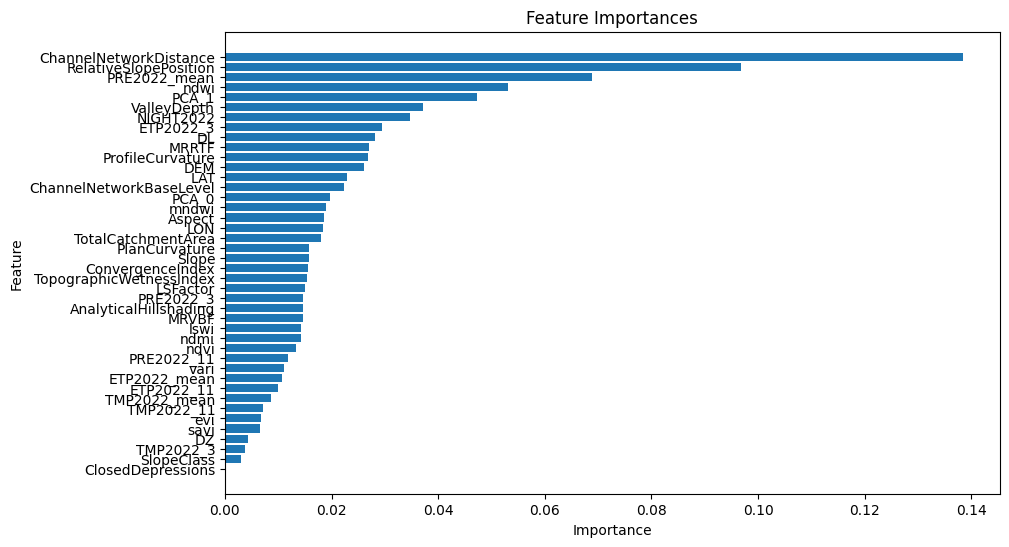

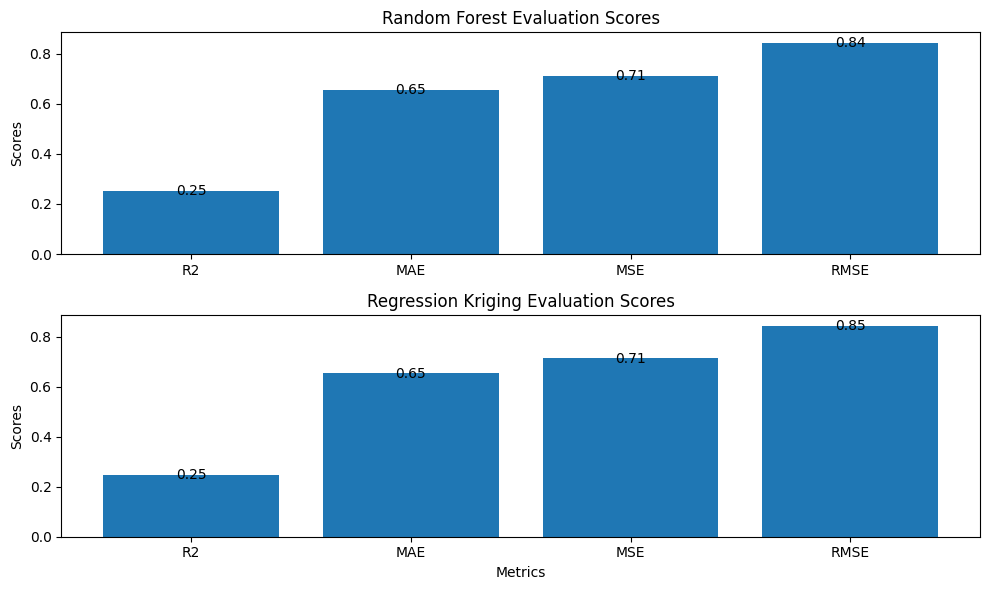

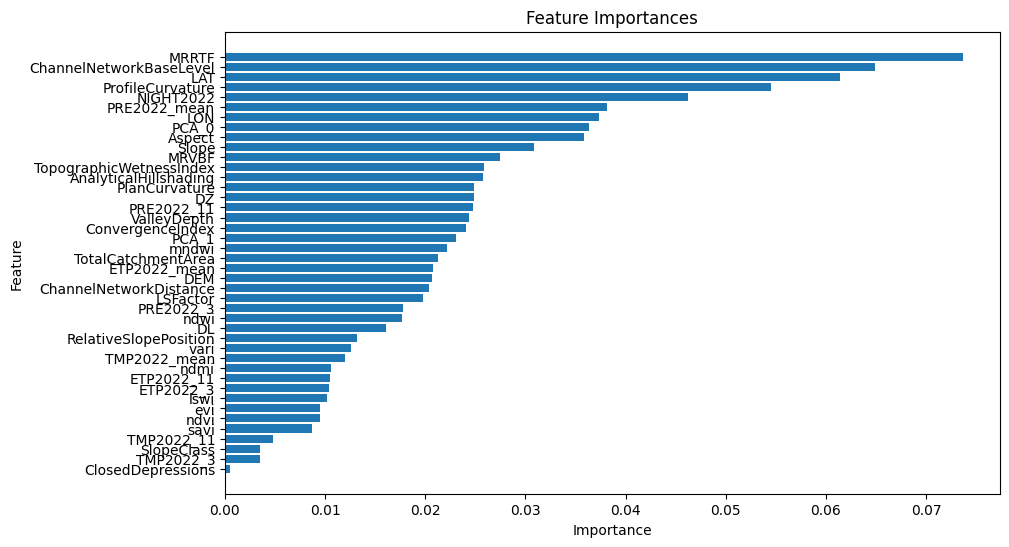

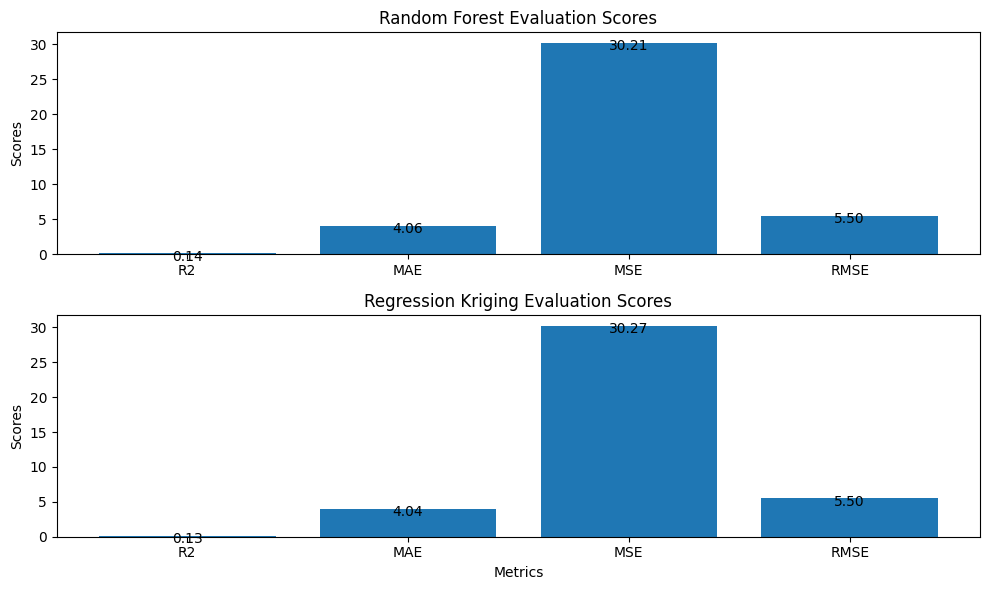

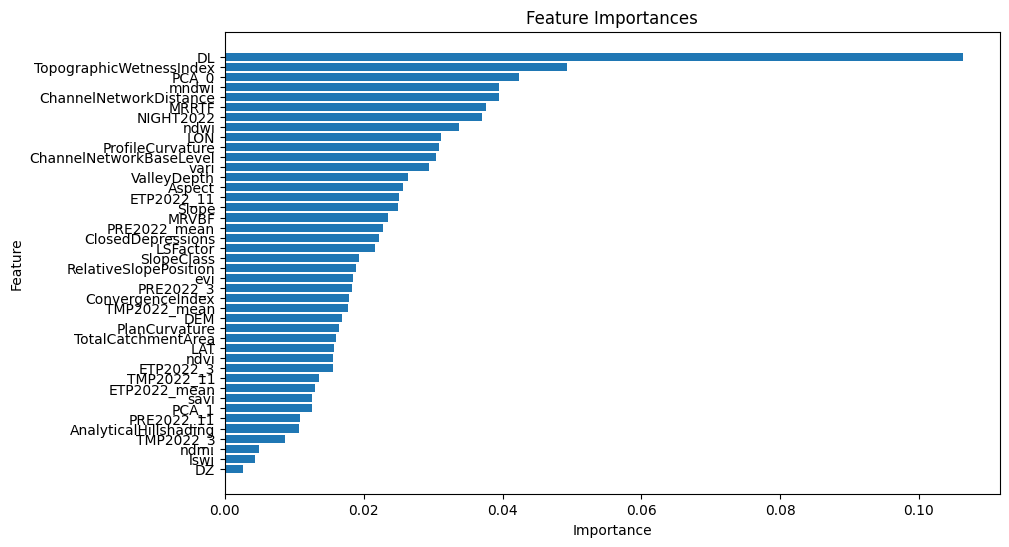

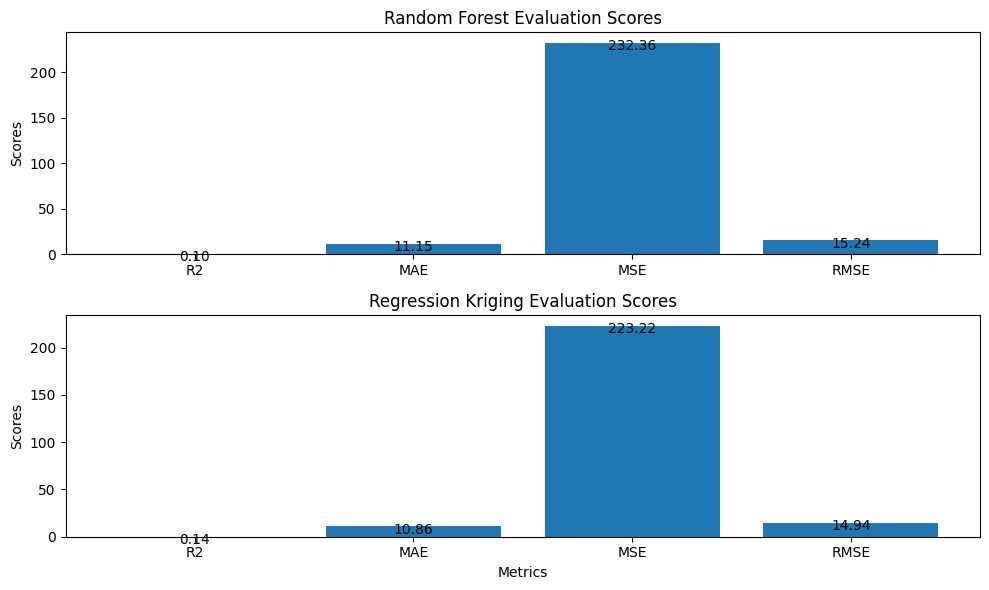

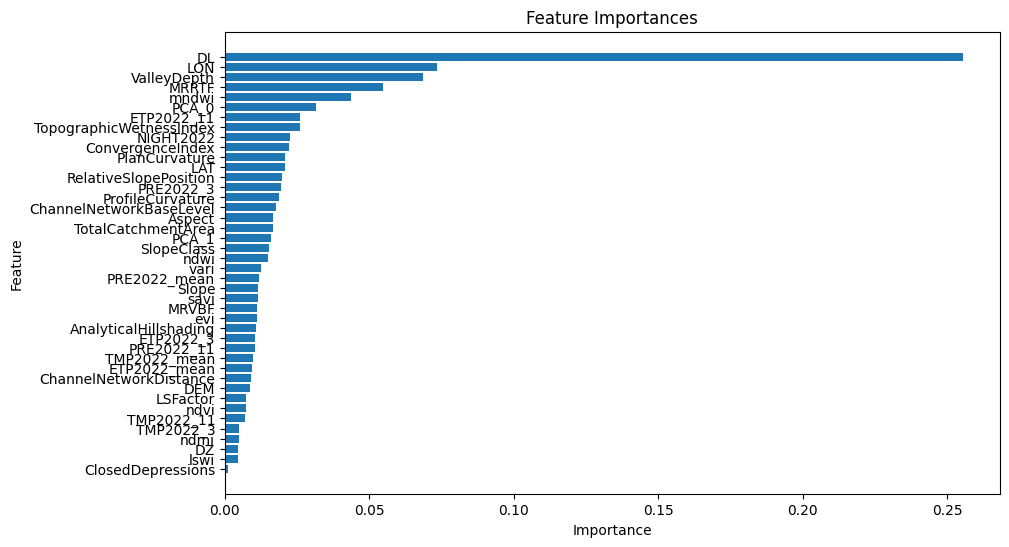

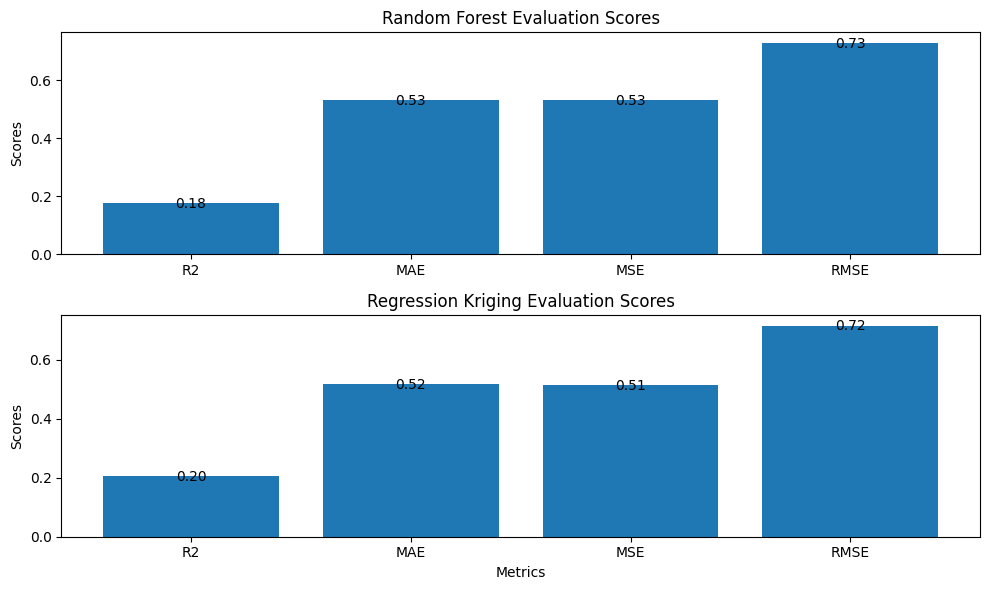

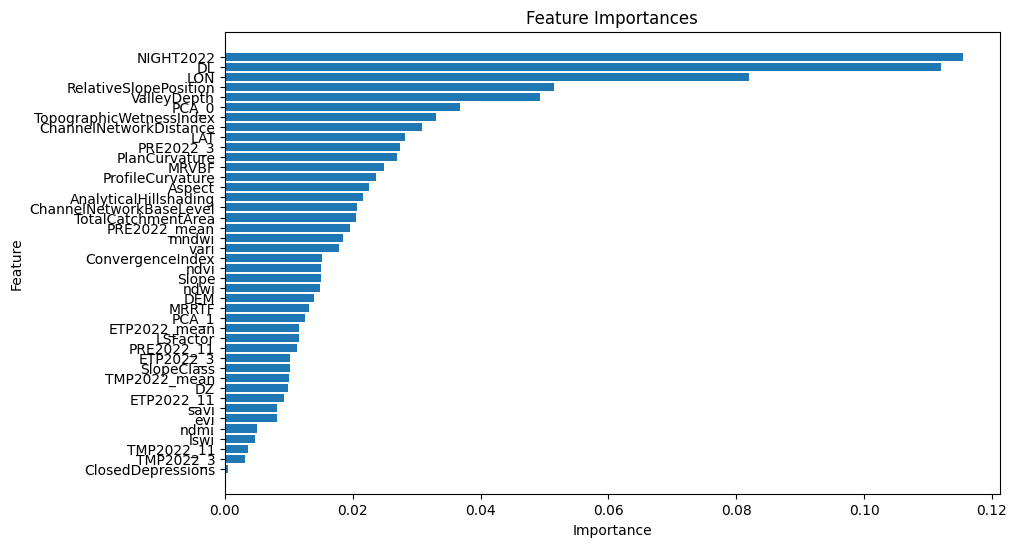

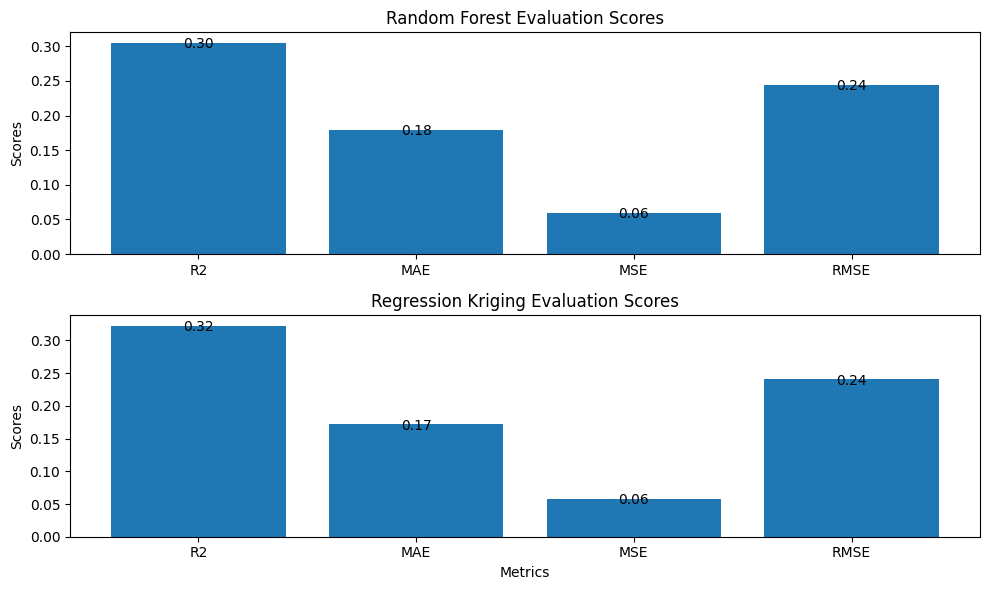

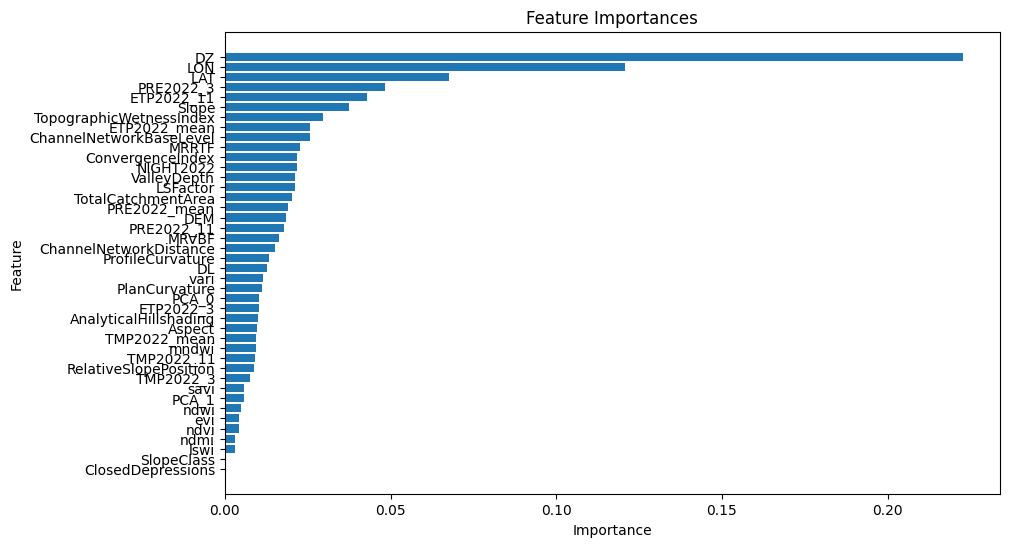

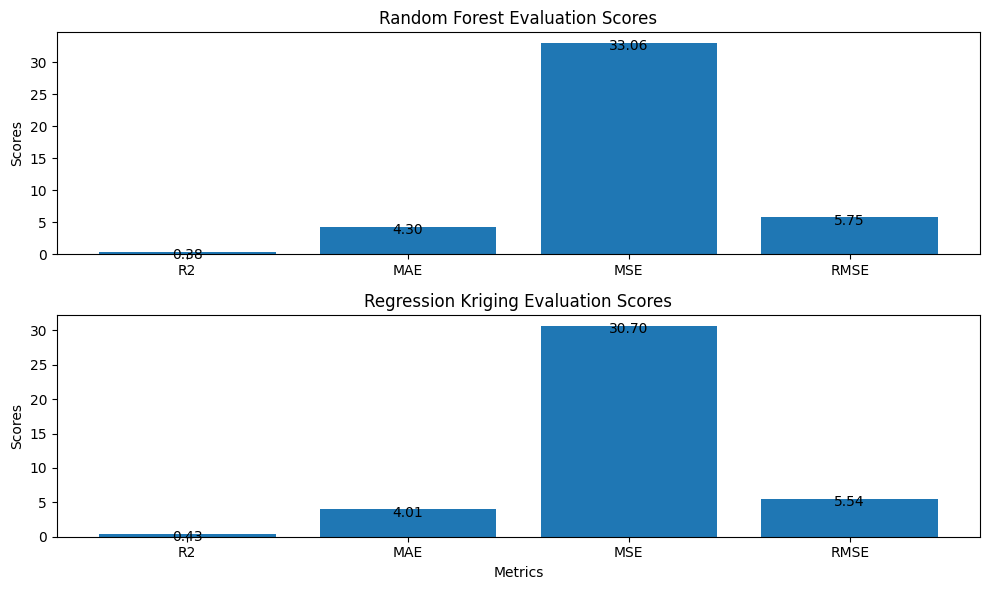

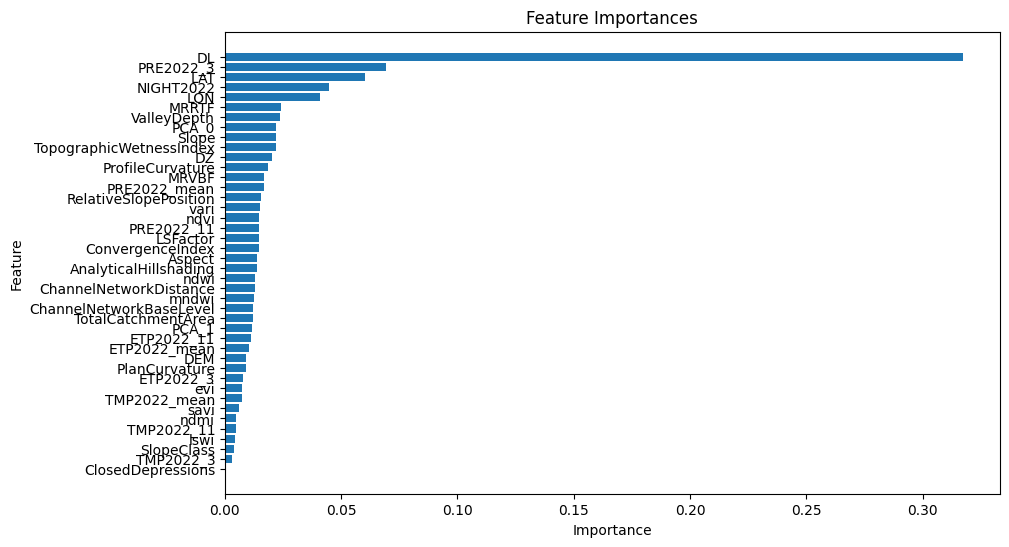

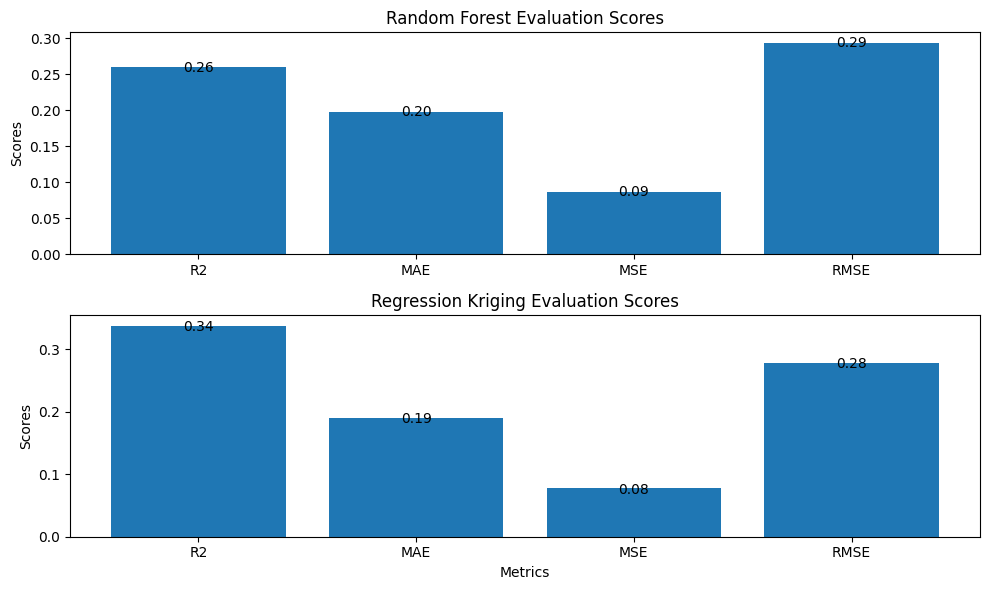

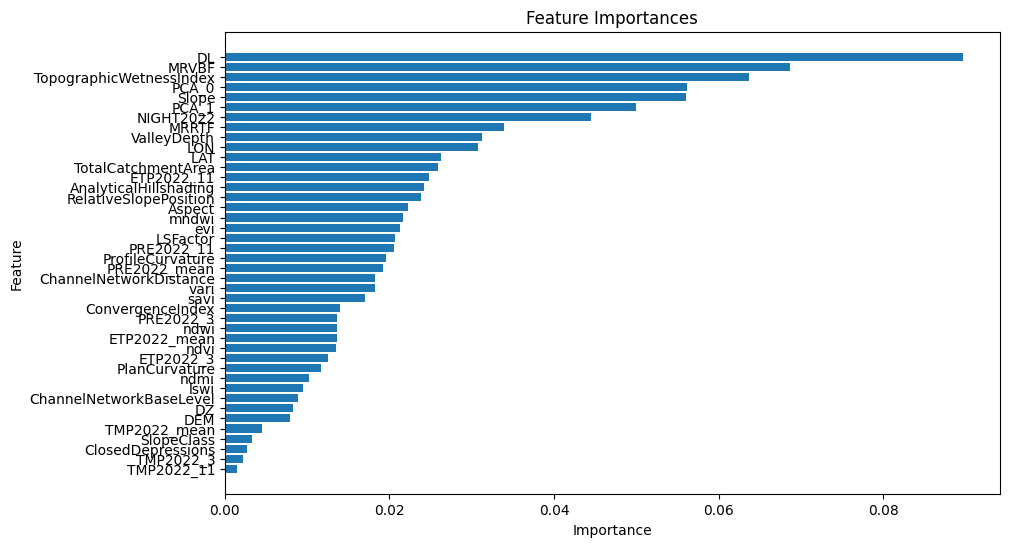

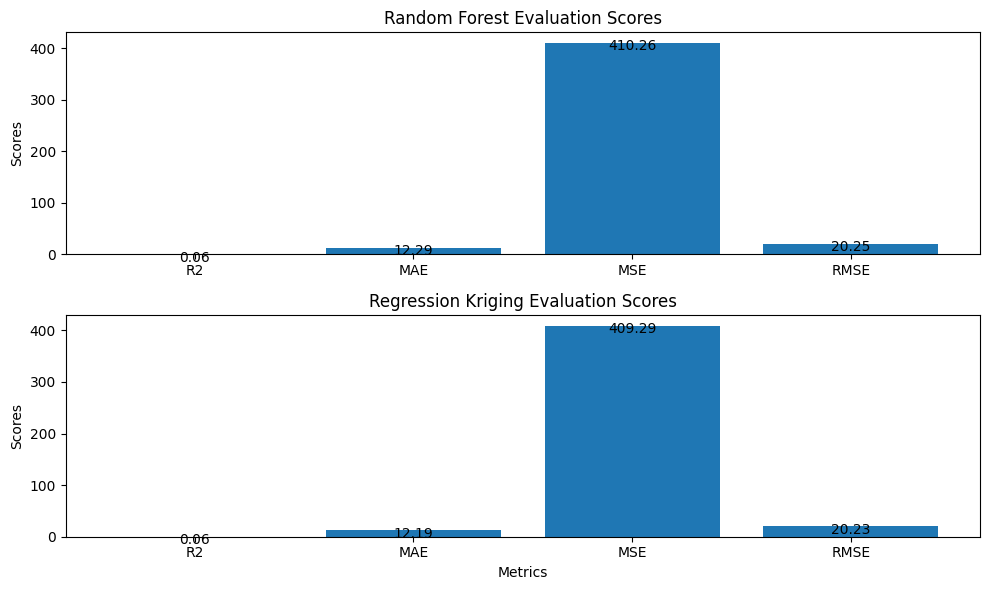

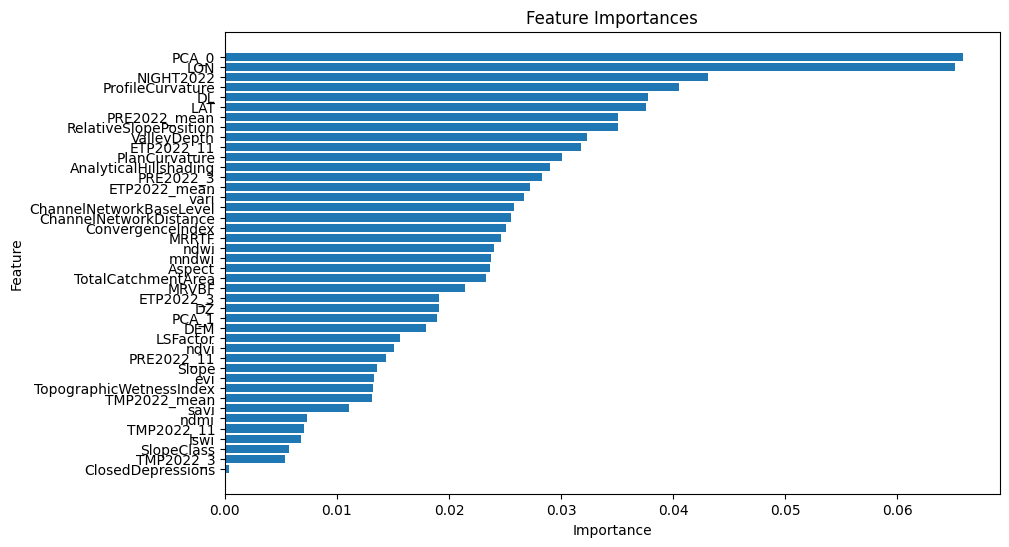

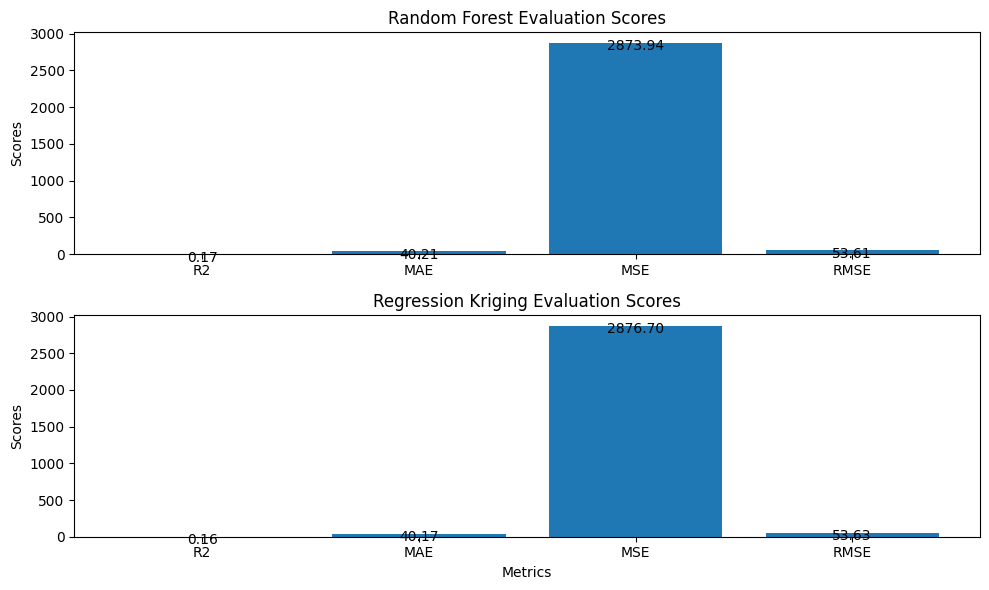

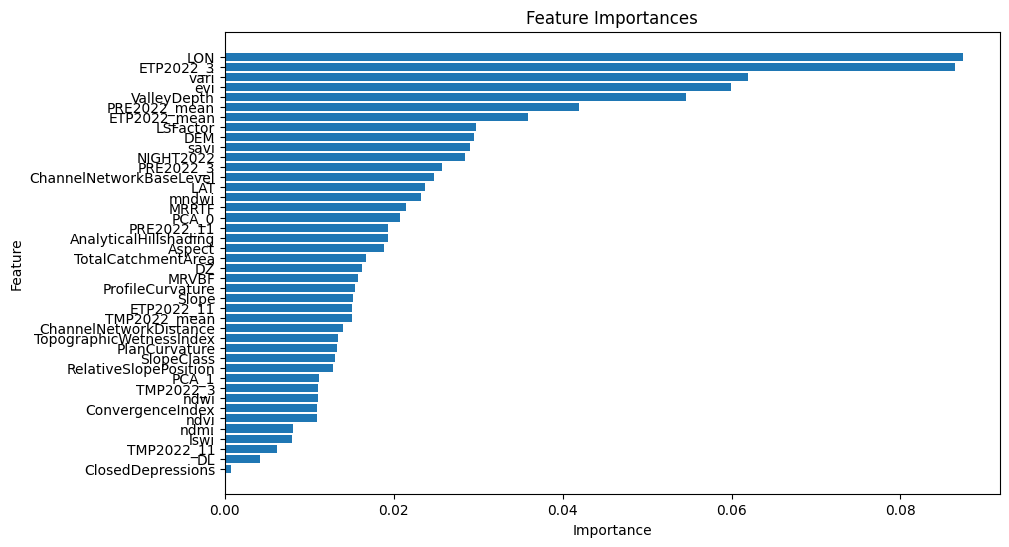

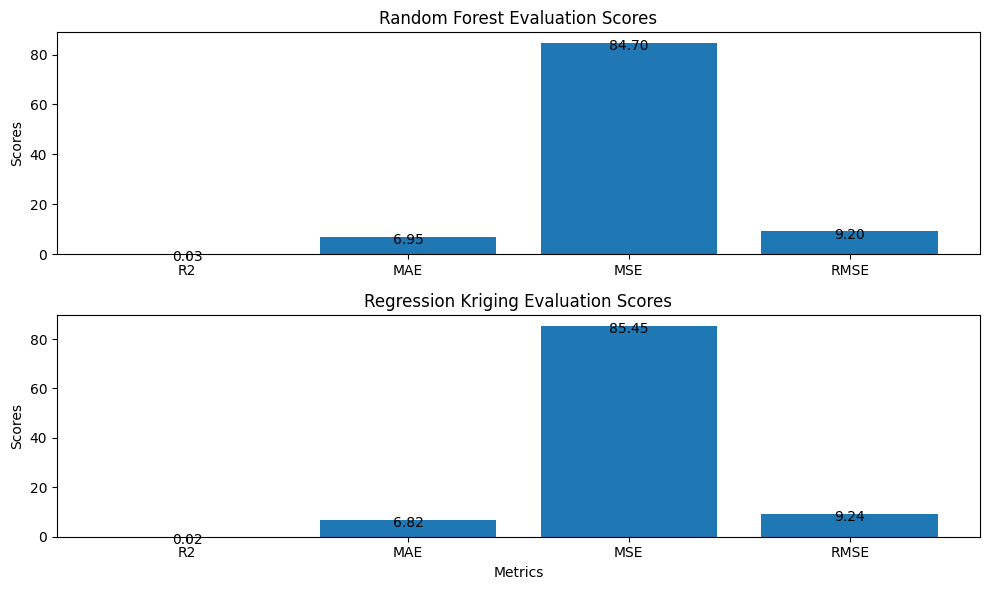

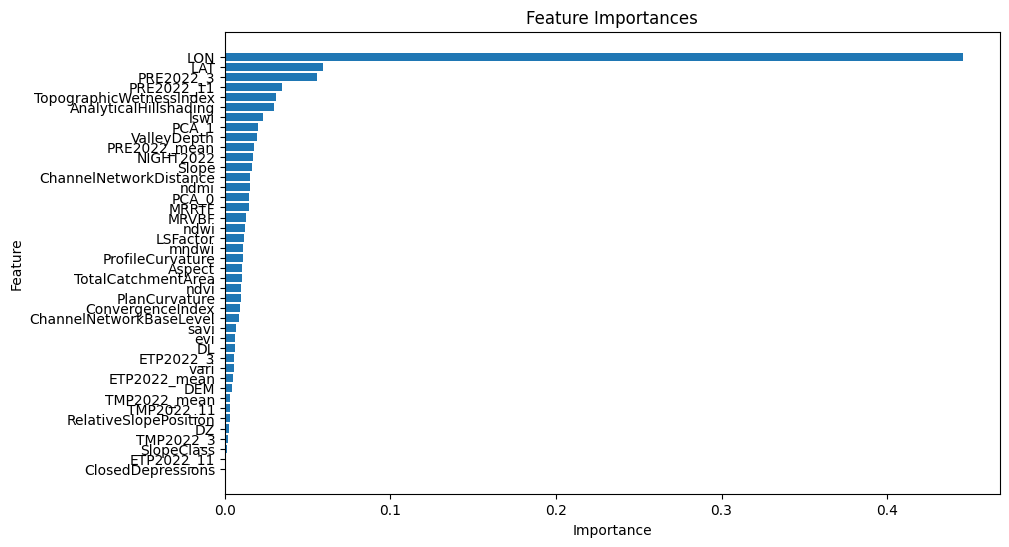

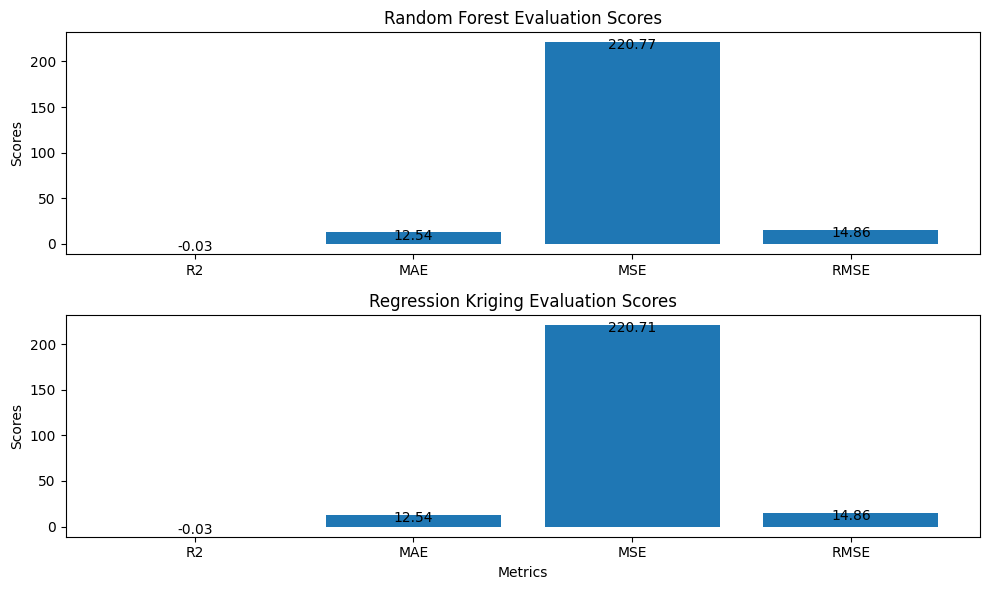

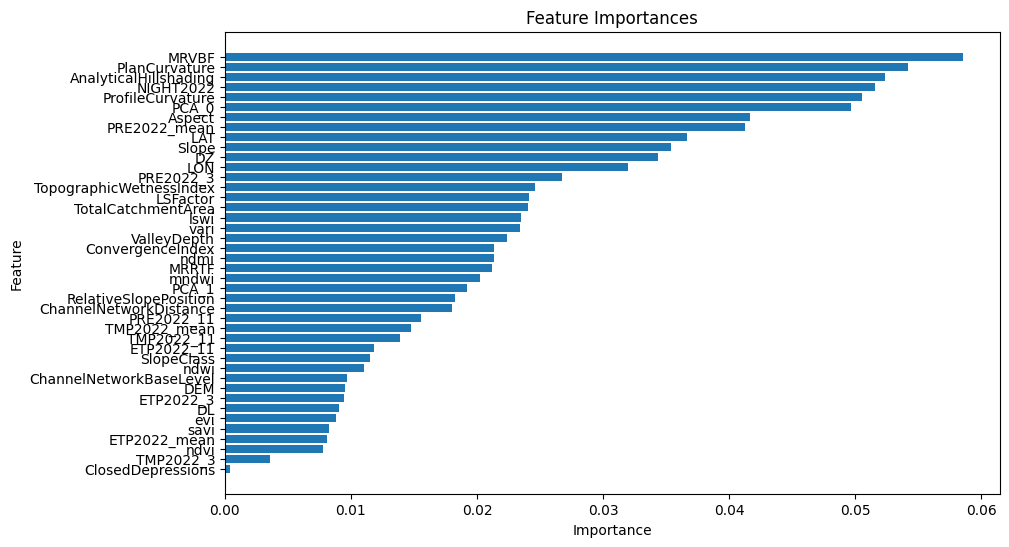

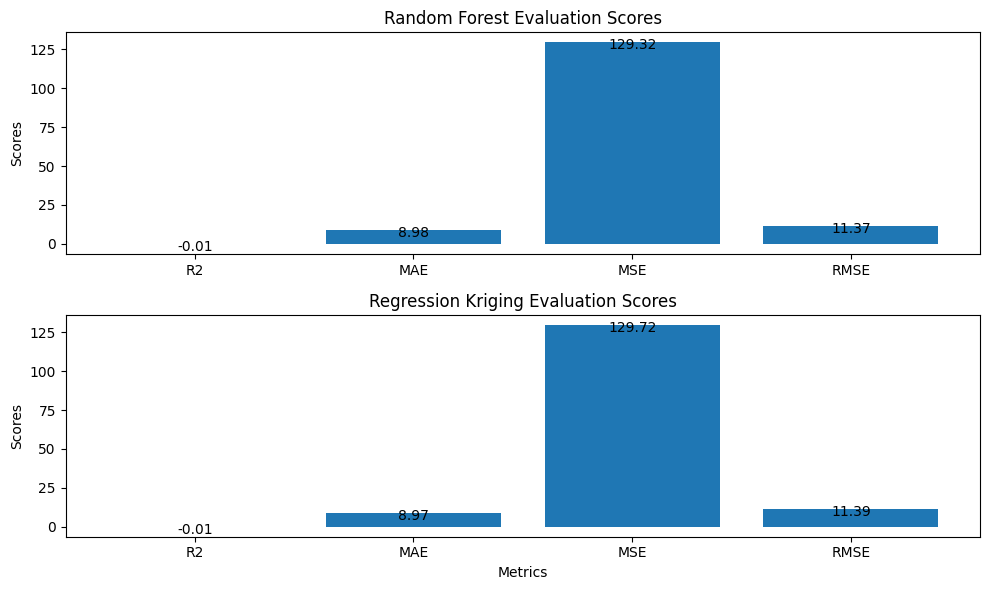

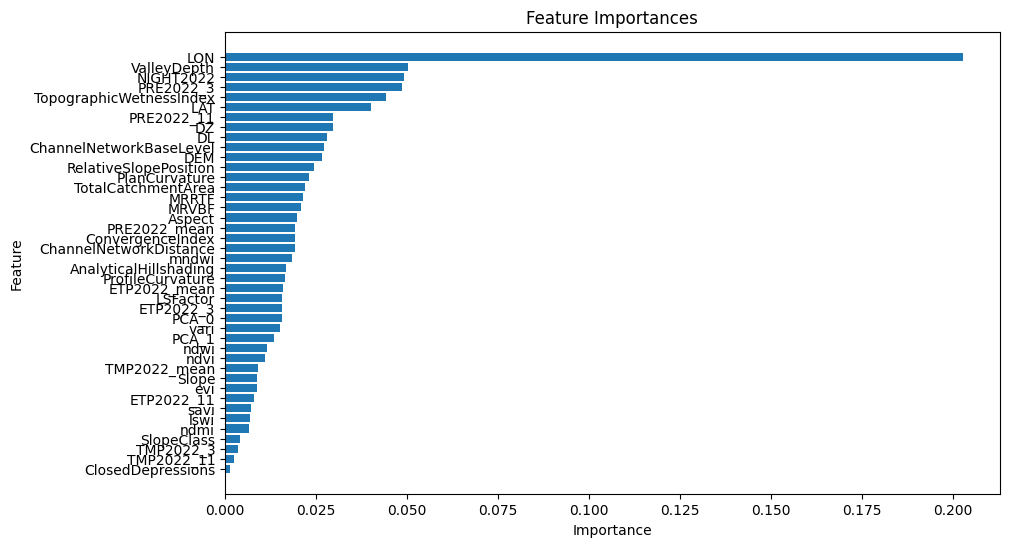

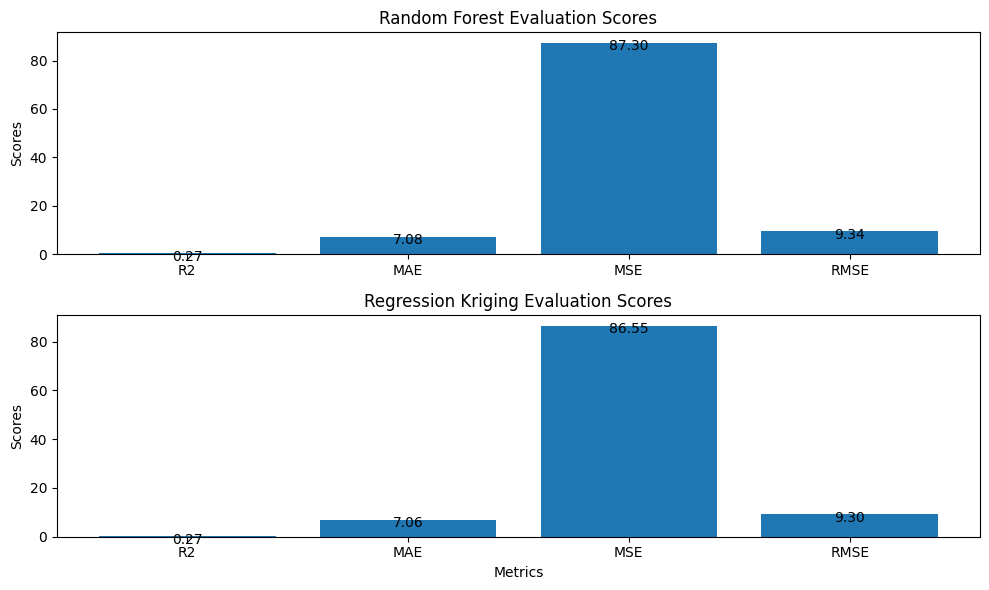

In [10]:
coord_cols = ["LON", "LAT"]
# 用户选择的标签列和特征列
# label_col = "ph"
feature_cols = ['DEM', 'AnalyticalHillshading', 'Aspect',
       'ChannelNetworkBaseLevel', 'ChannelNetworkDistance',
       'ClosedDepressions', 'ConvergenceIndex', 'LSFactor', 'MRRTF', 'MRVBF',
       'PlanCurvature', 'ProfileCurvature', 'RelativeSlopePosition', 'Slope',
       'TopographicWetnessIndex', 'TotalCatchmentArea', 'ValleyDepth',
       'NIGHT2022', 'ETP2022_mean', 'TMP2022_mean', 'PRE2022_mean',
       'PRE2022_3', 'PRE2022_11', 'ETP2022_3', 'ETP2022_11', 'TMP2022_3',
       'TMP2022_11', 'evi', 'lswi', 'mndwi', 'ndmi', 'ndvi', 'ndwi', 'PCA_0',
       'PCA_1', 'savi', 'vari', 'DL', 'DZ','SlopeClass']

# 用户指定的超参数调优范围
param_grid = {
    'n_estimators': np.arange(10, 1000, 10),
    'max_depth': [None] + list(np.arange(1, 100)),
    'min_samples_split': np.arange(2, 100),
    'min_samples_leaf': np.arange(1, 100),
}
# 逐个训练并导出
label_cols_list = ['ph', 'ylzjhl', 'yjz', 'qdan', 'qlin', 'qjia', 'qxi', 'yxlin', 'sxjia', 'jxzc11', 'jxzc12', 'jxzc13', 'jxzc14']
# rf模型目录
rf_dir = r"F:\cache_data\model_path\dy\rfrk"
for col in label_cols_list:
    print(col)
    # 选取符合条件的数据
    # pre_data = df[df[f"{col}_Status"]=='Normal']
    print(df.shape)
    pre_data = df[(df[f"{col}"]!=0.0001) & (df[f"{col}"]!=0.0002) & (df[f"{col}_Status"]=='Normal')]
    print(pre_data.shape)
    X = pre_data[feature_cols+coord_cols]
    y = pre_data[col]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    # 输出训练集和测试集的形状
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    # 模型存放位置,检查是否存在该目录,不存在则创建
    temp_dir_path = os.path.join(rf_dir,col)
    if not os.path.exists(temp_dir_path):
        os.makedirs(temp_dir_path)
    # 模型存放路径
    save_model_path =os.path.join(temp_dir_path,f"{col}_rf_model.pkl") 
    # 训练模型
    train_log = rf_classics(pre_data,col,feature_cols,coord_cols,param_grid,save_model_path)
    print(train_log)

# 处理分类问题

In [61]:
cl_data = pd.read_csv(r"F:\float_data\DY\marked_data.csv")
print(cl_data.shape)
cl_data = cl_data[cl_data['jxzc11'] != 0.0001]
print(cl_data.shape)
cl_data['jxzc15'] = cl_data['jxzc12']+cl_data['jxzc13']

(1159, 60)
(592, 60)


In [62]:
cl_data['soil_texure'] = cl_data.apply(lambda row: classify_soil_texture(row['jxzc11'], row['jxzc15'], row['jxzc14']), axis=1)


砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分比之和应大约为100%
砂粒、粉粒和粘粒的百分

In [65]:
cl_df = cl_data

soil_texure
(1159, 98)
(592, 62)
(473, 4) (119, 4) (473,) (119,)
Fitting 5 folds for each of 100 candidates, totalling 500 fits


d:\worker_code\.venvgis\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Random Parameters: 
 {'n_estimators': 770, 'min_samples_split': 53, 'min_samples_leaf': 5, 'max_depth': 92}
RandomSearch Test accuracy: 0.8991596638655462 RandomSearch Train accuracy: 0.9069767441860465
Random search best params: {'n_estimators': 770, 'min_samples_split': 53, 'min_samples_leaf': 5, 'max_depth': 92}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


d:\worker_code\.venvgis\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Grid Parameters: 
 {'max_depth': 87, 'min_samples_leaf': 4, 'min_samples_split': 51, 'n_estimators': 720}
GridSearch Test accuracy: 0.907563025210084 GridSearch Train accuracy: 0.904862579281184
Random Forest Accuracy: 0.907563025210084
Random Forest Precision: 0.8910948994982609
Random Forest Recall: 0.907563025210084
Random Forest F1-score: 0.8952965557824808


d:\worker_code\.venvgis\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'SelectedFeatures': ['jxzc11', 'jxzc12', 'jxzc13', 'jxzc14'], 'FeatureImportance':   Feature  Importance
3  jxzc14    0.741334
0  jxzc11    0.106198
1  jxzc12    0.105139
2  jxzc13    0.047329, 'RandomForest': {'Accuracy': 0.907563025210084, 'Precision': 0.8910948994982609, 'Recall': 0.907563025210084, 'F1-score': 0.8952965557824808}}


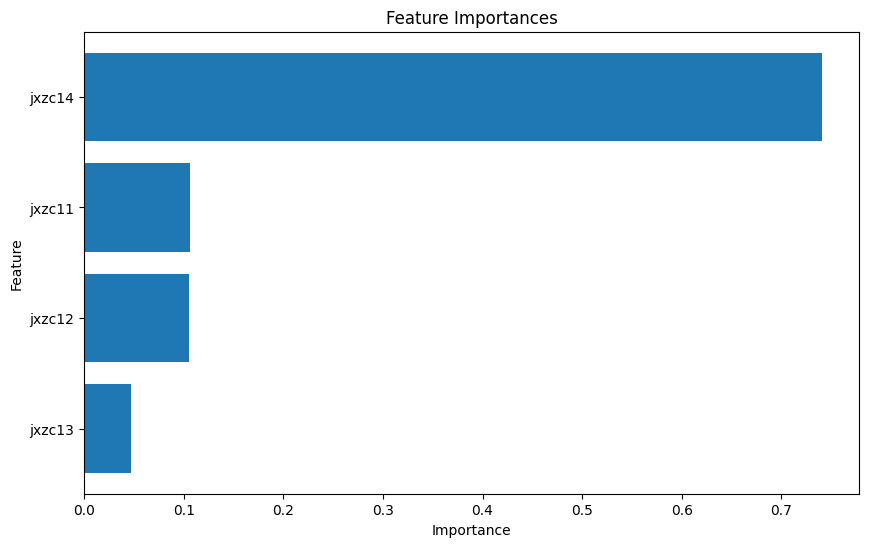

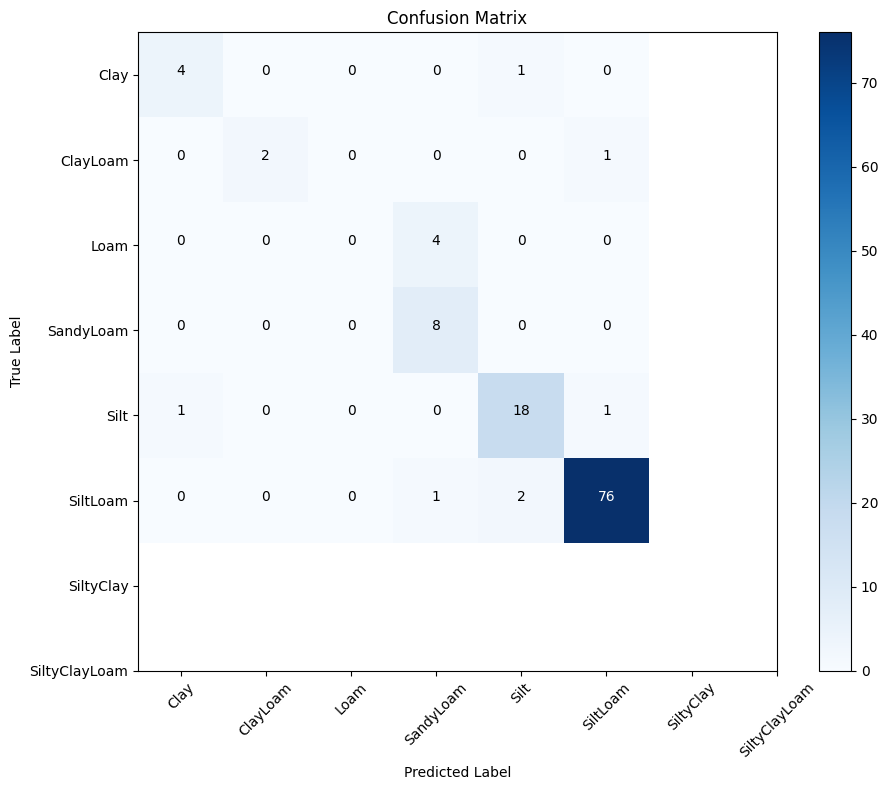

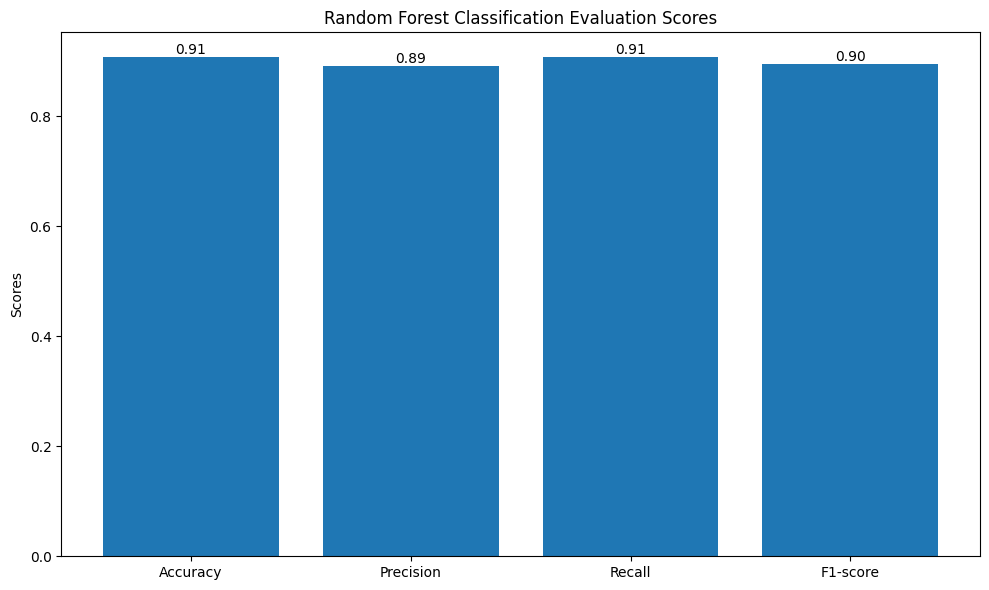

In [71]:
# 用户选择的标签列和特征列
feature_cols = ['jxzc11', 'jxzc12', 'jxzc13', 'jxzc14']
# 用户指定的超参数调优范围
param_grid = {
    'n_estimators': np.arange(10, 1000, 10),
    'max_depth': [None] + list(np.arange(1, 100)),
    'min_samples_split': np.arange(2, 100),
    'min_samples_leaf': np.arange(1, 100),
}
# 逐个训练并导出
label_cols_list = ['soil_texure']
# rf模型目录
rf_dir = r"F:\cache_data\model_path\dy\rfrk"
for col in label_cols_list:
    print(col)
    # 选取符合条件的数据
    # pre_data = df[df[f"{col}_Status"]=='Normal']
    print(df.shape)
    pre_data = cl_df[(cl_df[f"{col}"]!=0.0001) & (cl_df[f"{col}"]!=0.0002)]
    print(pre_data.shape)
    X = pre_data[feature_cols]
    y = pre_data[col]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    # 输出训练集和测试集的形状
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    # 模型存放位置,检查是否存在该目录,不存在则创建
    temp_dir_path = os.path.join(rf_dir,col)
    if not os.path.exists(temp_dir_path):
        os.makedirs(temp_dir_path)
    # 模型存放路径
    save_model_path =os.path.join(temp_dir_path,f"{col}_rf_model.pkl") 
    # 训练模型
    train_log = rf_classics_classification(pre_data,col,feature_cols,param_grid,save_model_path)
    print(train_log)